In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
#from pyearth import Earth

In [2]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [x.strip() for x in data.columns.tolist()]
X = data.drop(columns = ['weekday_is_monday',
 'weekday_is_saturday',
 'LDA_00',
 'n_unique_tokens',
 'n_non_stop_words',
 'self_reference_avg_sharess',
 'rate_positive_words',
 'LDA_04',
 'LDA_02',
 'kw_max_max',
 'kw_avg_min',
 'kw_avg_avg',
 'rate_negative_words',
 'min_negative_polarity', 'url', 'timedelta', 'shares'])
y = data['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

# We will start tuning parameters one by one to look for a general range to look for, for when we tune all the parameters at the same time

### Number of trees
We will use the same number of trees - 100 for all future fitting, until the final model, because we will be using the early_stopping_rounds of the XGBRegressor to determine the right number of trees.

### Depth of the model

>1 2410.643 (229.324)
>2 2403.561 (231.199)
>3 2404.479 (232.812)
>4 2414.343 (232.710)
>5 2433.291 (233.620)
>6 2447.415 (226.553)
>7 2469.566 (235.096)
>8 2489.745 (232.133)
>9 2505.990 (227.905)
>10 2510.741 (236.067)
>11 2517.086 (230.617)
>12 2518.309 (230.329)
>13 2530.547 (227.740)
>14 2532.195 (227.782)
>15 2528.349 (223.834)
>16 2533.048 (223.466)
>17 2536.756 (229.450)
>18 2532.867 (231.111)
>19 2527.820 (226.332)
>20 2528.956 (222.060)


Text(0.5, 0, 'Depth of each tree')

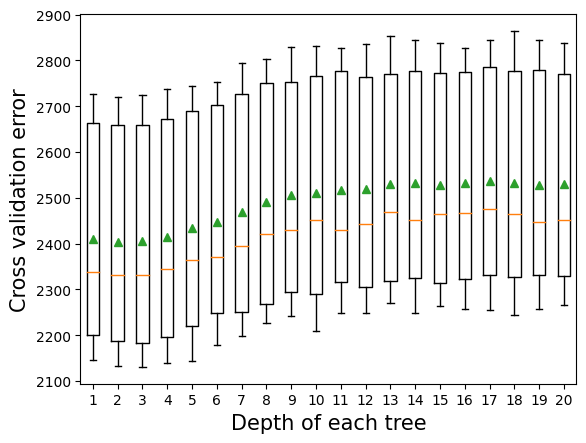

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

### Learning rate

>0.0100 3278.7 (230.8)
>0.0500 2384.8 (232.9)
>0.1000 2398.3 (232.7)
>0.2000 2418.4 (232.6)
>0.3000 2447.4 (226.6)
>0.4000 2496.7 (231.1)
>0.5000 2558.3 (245.8)
>0.6000 2611.6 (235.0)
>0.8000 2778.3 (234.6)
>1.0000 3088.1 (368.1)


Text(0.5, 0, 'Learning rate')

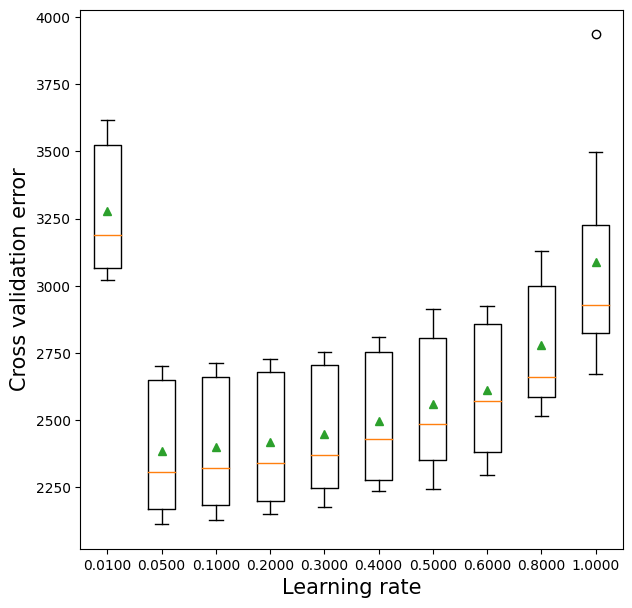

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

### Regularization

>0.0000 2478.5 (236.6)
>10.0000 2431.6 (235.5)
>100.0000 2416.1 (233.4)
>1000.0000 2397.8 (232.8)
>10000.0000 2397.5 (232.0)
>100000.0000 2436.6 (228.3)
>1000000.0000 3331.9 (231.0)
>10000000.0000 3414.4 (230.9)
>100000000.0000 3415.5 (230.9)


Text(0.5, 0, 'reg_lambda')

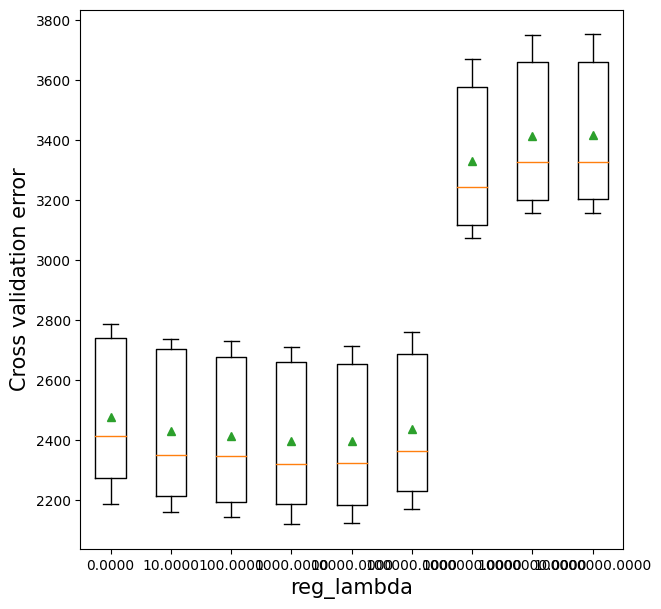

In [ ]:
# Fine tune more general range for regularization
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

Regularization alpha

>0.0000 2447.4 (226.6)
>10.0000 2426.5 (236.9)
>100.0000 2397.7 (232.3)
>1000.0000 2435.3 (228.1)
>10000.0000 2494.0 (230.6)
>100000.0000 3364.5 (231.0)
>1000000.0000 3415.6 (230.9)
>10000000.0000 3415.6 (230.9)
>100000000.0000 3415.6 (230.9)


Text(0.5, 0, 'reg_alpha')

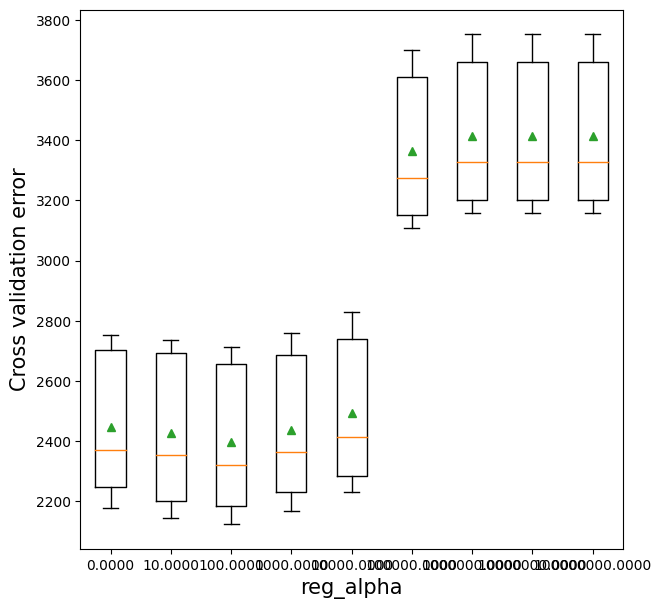

In [ ]:
# Fine tune more general range for regularization
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_alpha=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_alpha',fontsize=15)

### Regularization in gamma

>0.0000 2447.4 (226.6)
>10.0000 2406.6 (233.7)
>100.0000 2434.8 (226.7)
>1000.0000 2498.7 (228.5)
>10000.0000 2513.6 (228.4)
>100000.0000 2513.6 (228.4)
>1000000.0000 2513.6 (228.4)
>10000000.0000 2513.6 (228.4)
>100000000.0000 2513.6 (228.4)
>1000000000.0000 2513.6 (228.4)


Text(0.5, 0, 'gamma')

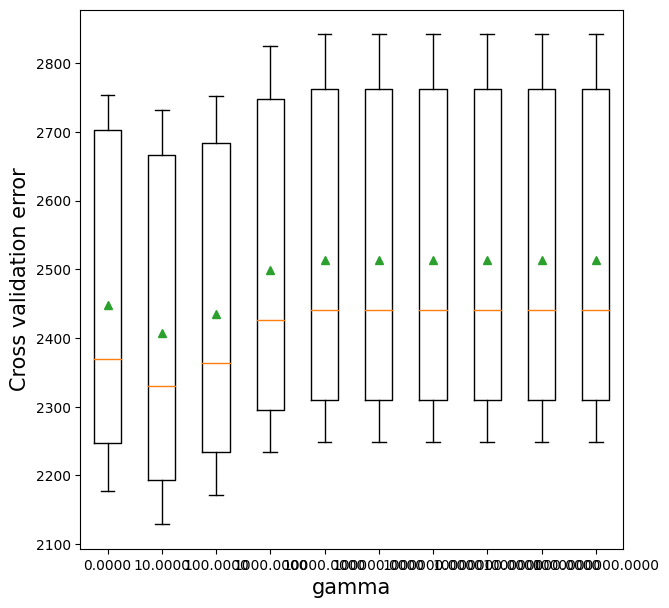

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

### Tuning full model with everything

In [10]:
y_train = y_train.apply(lambda x: y_train.mean() if np.isnan(x) else x)

In [11]:
#K-fold cross validation to find optimal parameters for XGBoost
# Finer search
start_time = time.time()
param_grid = {'regressor__max_depth': [2, 4, 6, 8, 10],
              'regressor__learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0],
              'regressor__reg_alpha':[0, 5, 10, 100, 500],
               'regressor__reg_lambda':[0, 5, 10, 100, 500],
                'regressor__n_estimators':[1000, 3000, 5000],
                'regressor__gamma': [0, 2, 4, 6, 8, 11, 14, 17],
                'regressor__subsample': [0.3, 0.4, 0.6, 0.75, 1],
                'regressor__colsample_bytree': [0.5, 0.75, 1]}

estimator = TransformedTargetRegressor(xgb.XGBRegressor(random_state=1), func = np.log, inverse_func = np.exp)

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=estimator,                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1, scoring = 'neg_mean_absolute_error',
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation MAE = ",-optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-2.31265935e+03 -2.37665905e+03 -2.34899420e+03 -2.32885755e+03
 -2.35725306e+03 -3.48558027e+03 -2.37857691e+03 -2.37888727e+03
 -2.62636761e+03 -2.32692330e+03 -2.35025575e+03 -2.34991048e+03
 -2.33222756e+03 -2.35752937e+03 -2.31985839e+03 -2.74454420e+03
 -2.51992723e+03 -3.95206705e+04 -2.32509405e+03 -2.34049672e+03
 -2.60165296e+03 -2.35026964e+03 -2.45131550e+03 -2.35887239e+03
 -2.37507878e+03 -2.33490413e+03             nan -2.48384781e+03
 -2.31350960e+03 -2.37399865e+03 -2.78434543e+03 -2.32353129e+03
 -2.31339342e+03 -2.37835577e+03 -2.38018335e+03 -2.32820795e+03
 -2.32579821e+03           

Optimal parameter values = {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 5, 'regressor__n_estimators': 1000, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.01, 'regressor__gamma': 6, 'regressor__colsample_bytree': 0.75}
Optimal cross validation MAE =  2309.3118685193926
Time taken =  58  minutes


In [ ]:
xgb_model = xgb.XGBRegressor(random_state = 1, max_depth = 4, learning_rate = 0.01,
                        n_estimators = 20000,reg_lambda = 0, reg_alpha = 5, gamma = 6, subsample = 0.6, 
                         colsample_bytree = 0.75, early_stopping_rounds = 250, eval_metric = mean_absolute_error)
xgb_model = TransformedTargetRegressor(xgb_model, func = np.log, inverse_func = np.exp)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = \
train_test_split(X_train, y_train, test_size = 0.2, random_state = 45)

xgb_model.fit(X_train_sub, y_train_sub, eval_set = ([(X_test_sub, y_test_sub)]))

In [14]:
print('XGBoost MAE is {}'.format(mean_absolute_error(y_test, xgb_model.predict(X_test))))

XGBoost MAE is 2175.030488719755


In [15]:
#K-fold cross validation to find optimal parameters for XGBoost
# Finer search
start_time = time.time()
param_grid = {'regressor__max_depth': [2, 3, 4, 5, 6],
              'regressor__learning_rate': [0.001, 0.005, 0.01, 0.1, 0.5],
              'regressor__reg_alpha':[0, 2, 4, 5, 7, 9, 10],
               'regressor__reg_lambda':[0, 1, 2, 3, 4],
                'regressor__n_estimators':[500, 1000, 1500, 3000],
                'regressor__gamma': [0, 2, 4, 5, 6, 7, 8, 10],
                'regressor__subsample': [0.5, 0.55, 0.6, 0.65, 0.7],
                'regressor__colsample_bytree': [0.65, 0.75, 0.85]}

estimator = TransformedTargetRegressor(xgb.XGBRegressor(random_state=1), func = np.log, inverse_func = np.exp)

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=estimator,                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1, scoring = 'neg_mean_absolute_error',
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation MAE = ",-optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'regressor__subsample': 0.6, 'regressor__reg_lambda': 3, 'regressor__reg_alpha': 2, 'regressor__n_estimators': 1000, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.005, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.75}
Optimal cross validation MAE =  2299.2292476767043
Time taken =  23  minutes


In [19]:
xgb_model = xgb.XGBRegressor(random_state = 1, max_depth = 5, learning_rate = 0.001,
                        n_estimators = 20000,reg_lambda = 3, reg_alpha = 2, gamma = 0, subsample = 0.6, 
                         colsample_bytree = 0.75, early_stopping_rounds = 250, eval_metric = mean_absolute_error)
xgb_model = TransformedTargetRegressor(xgb_model, func = np.log, inverse_func = np.exp)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = \
train_test_split(X_train, y_train, test_size = 0.2, random_state = 45)

xgb_model.fit(X_train_sub, y_train_sub, eval_set = ([(X_test_sub, y_test_sub)]))

Streaming output truncated to the last 5000 lines.
[4319]	validation_0-rmse:9775.20919	validation_0-mean_absolute_error:3149.00171
[4320]	validation_0-rmse:9775.20916	validation_0-mean_absolute_error:3149.00171
[4321]	validation_0-rmse:9775.20914	validation_0-mean_absolute_error:3149.00171
[4322]	validation_0-rmse:9775.20912	validation_0-mean_absolute_error:3149.00171
[4323]	validation_0-rmse:9775.20904	validation_0-mean_absolute_error:3149.00146
[4324]	validation_0-rmse:9775.20901	validation_0-mean_absolute_error:3149.00146
[4325]	validation_0-rmse:9775.20898	validation_0-mean_absolute_error:3149.00122
[4326]	validation_0-rmse:9775.20895	validation_0-mean_absolute_error:3149.00122
[4327]	validation_0-rmse:9775.20892	validation_0-mean_absolute_error:3149.00122
[4328]	validation_0-rmse:9775.20887	validation_0-mean_absolute_error:3149.00098
[4329]	validation_0-rmse:9775.20886	validation_0-mean_absolute_error:3149.00098
[4330]	validation_0-rmse:9775.20884	validation_0-mean_absolute_error:

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=0.75,
                                                  early_stopping_rounds=250,
                                                  enable_categorical=False,
                                                  eval_metric=<function mean_absolute_error at 0x7fd9b5066cb0>,
                                                  feature_types=None, gamma=0,
                                                  gpu_id=None, grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=0.001,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=5, max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=20000,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=1, ...))

In [20]:
print('XGBoost MAE is {}'.format(mean_absolute_error(y_test, xgb_model.predict(X_test))))

XGBoost MAE is 2171.301622112978


In [ ]:
# Before
print('XGBoost MAE is {}'.format(mean_absolute_error(y_test, xgb_model.predict(X_test))))

XGBoost MAE is 2274.2956126599524
